# Télecharger le jeu de données

In [71]:
import polars as pl
import requests
import polars.selectors as cs
from pathlib import Path
import plotly.express as px
import os
import polars as pl
import pandas as pd 
import folium
import matplotlib.pyplot as plt

In [72]:
# Si dossier /dataset vide ou que son contenu est vide, alors télécharger les données
rootPath = Path(".").parent
datasetFolder = rootPath / "voitures.csv"
if not os.path.exists(datasetFolder):
    print("la donnée n'est pas chargée")
else:
    print("Chargement de la donnée")
    df = pl.read_csv("voitures.csv", separator=";", ignore_errors=True)
    print(df)

Chargement de la donnée
shape: (4_521, 8)
┌────────────┬────────┬───────┬───────┬─────────────┬─────────┬────────────────┬─────────────┐
│ marque     ┆ modele ┆ prix  ┆ annee ┆ kilometrage ┆ energie ┆ nombre chevaux ┆ code postal │
│ ---        ┆ ---    ┆ ---   ┆ ---   ┆ ---         ┆ ---     ┆ ---            ┆ ---         │
│ str        ┆ str    ┆ i64   ┆ i64   ┆ i64         ┆ str     ┆ i64            ┆ i64         │
╞════════════╪════════╪═══════╪═══════╪═════════════╪═════════╪════════════════╪═════════════╡
│ Peugeot    ┆ 2008   ┆ 9990  ┆ 2018  ┆ 90737       ┆ essence ┆ 2008121106     ┆ 89000       │
│ Peugeot    ┆ 2008   ┆ 13990 ┆ 2021  ┆ 134396      ┆ essence ┆ 20081308       ┆ 78200       │
│ Peugeot    ┆ 2008   ┆ 15980 ┆ 2021  ┆ 55330       ┆ essence ┆ 20081308       ┆ 78240       │
│ Peugeot    ┆ 3008   ┆ 14999 ┆ 2022  ┆ 61412       ┆ essence ┆ 1308           ┆ 83300       │
│ Peugeot    ┆ 2008   ┆ 27480 ┆ 2021  ┆ 137039      ┆ essence ┆ 1308           ┆ 59300       │
│ …     

# Traitement initial de la base

In [73]:
# Suppression des doublons 
df = df.unique(subset=["annee", "kilometrage", "prix"], keep="first")

df.shape

(3849, 8)

In [74]:
# Valeurs nulles dans les colonnes
df.null_count()

# Suppression
df = df.drop_nulls()

df.shape

(3582, 8)

In [75]:
print(df.columns)

['marque', 'modele', 'prix', 'annee', 'kilometrage', 'energie', 'nombre chevaux', 'code postal']


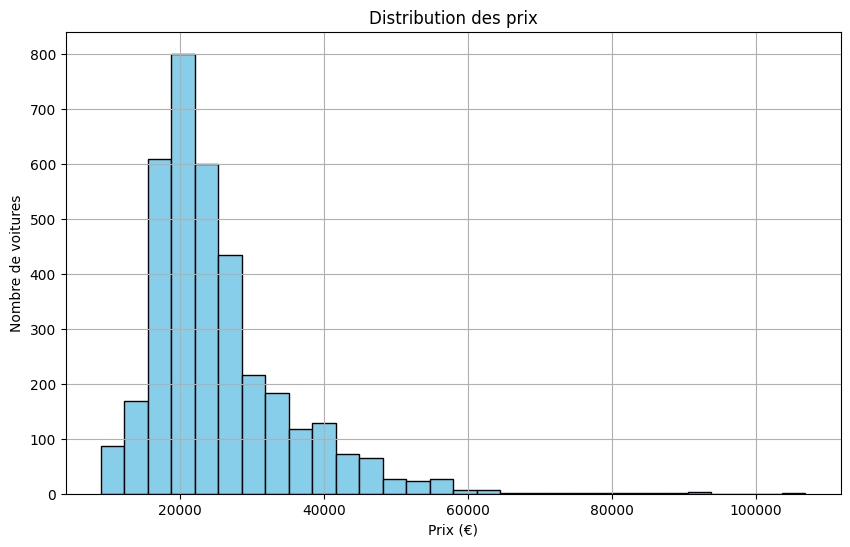

(543, 8)

In [76]:
# Conversion en pandas si ce n'est pas déjà fait
df_pandas = df.to_pandas()

# Histogramme
plt.figure(figsize=(10, 6))
plt.hist(df_pandas["prix"].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution des prix")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de voitures")
plt.grid(True)
plt.show()

# Il y'a un prix aberrant à enlever, on va garder ceux de moins de 80k€
df = df.filter(pl.col("nombre chevaux") <= 80000)

# Filtre sur le nombre de chevaux
df = df.filter((pl.col("nombre chevaux") >= 50) & (pl.col("nombre chevaux") <= 400))

df.shape
# On passe de 3500 à 500 véhicule si on veut prendre en compte le nombre de chevaux, c'est à dire la puissance du moteur

# Enrichissement de la base de données avec les coordonnées gps via une API gouvernementale

In [ ]:
import requests
import polars as pl

# Fonction pour obtenir les coordonnées GPS, le nom de la ville et la région
def get_geo_info(postal_code):
    # Appel à l'API adresse pour obtenir les coordonnées et la ville
    url = f"https://api-adresse.data.gouv.fr/search/?q={postal_code}&limit=1"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        features = data.get('features')
        
        if features:
            geometry = features[0].get('geometry')
            properties = features[0].get('properties')
            
            # Coordonnées GPS
            if geometry:
                lon, lat = geometry.get('coordinates')
            else:
                lon, lat = None, None

            # Ville
            city = properties.get('city', None)

            # Appel à l'API geo pour obtenir la région (via nom de ville)
            if city:
                geo_url = f"https://geo.api.gouv.fr/communes?nom={city}&fields=region&format=json"
                geo_response = requests.get(geo_url)
                if geo_response.status_code == 200:
                    geo_data = geo_response.json()
                    if geo_data:
                        region = geo_data[0]["region"]["nom"]
                        return lat, lon, city, region

            return lat, lon, city, None
    
    return None, None, None, None

# Appliquer la fonction sur les codes postaux
postal_codes = df['code postal'].to_list()

geo_infos = [get_geo_info(code) for code in postal_codes]

# Ajouter les nouvelles colonnes à ton DataFrame Polars
df = df.with_columns(
    pl.Series("latitude", [info[0] for info in geo_infos]),
    pl.Series("longitude", [info[1] for info in geo_infos]),
    pl.Series("ville", [info[2] for info in geo_infos]),
    pl.Series("région", [info[3] for info in geo_infos])
)

# Afficher le résultat
print(df.head())


In [ ]:
df.columns

['marque',
 'modele',
 'prix',
 'annee',
 'kilometrage',
 'energie',
 'nombre chevaux',
 'code postal',
 'latitude',
 'longitude',
 'ville',
 'région']

# Statistiques descriptives

In [ ]:
df.head()

marque,modele,prix,annee,kilometrage,energie,nombre chevaux,code postal,latitude,longitude,ville,région
str,str,i64,i64,i64,str,i64,i64,f64,f64,str,str
"""Renault""","""Captur""",23990,2019,56150,"""Diesel""",145,64100,43.488544,-1.466564,"""Bayonne""","""Nouvelle-Aquitaine"""
"""Renault""","""Arkana""",21990,2022,81661,"""hybride""",145,13008,43.247182,5.374045,"""Marseille 8e Arrondissement""",null
"""Renault""","""Megane""",21500,2024,10601,"""essence""",115,64500,43.391942,-1.633128,"""Saint-Jean-de-Luz""","""Nouvelle-Aquitaine"""
"""Renault""","""Arkana""",21990,2021,116406,"""Diesel""",140,58200,47.407726,2.93582,"""Cosne-Cours-sur-Loire""","""Bourgogne-Franche-Comté"""
"""Peugeot""","""e-2008""",22490,2021,17500,"""essence""",136,66000,42.701392,2.902878,"""Perpignan""","""Occitanie"""


In [ ]:
df.describe()
# Nos véhicules présents sont assez récents, avec une date de sortie d'en moyenne 2022, le plus ancien est de 2017
# ils présentent un prix moyen de 24425 €.

statistic,marque,modele,prix,annee,kilometrage,energie,nombre chevaux,code postal,latitude,longitude,ville,région
str,str,str,f64,f64,f64,str,f64,f64,f64,f64,str,str
"""count""","""543""","""543""",543.0,543.0,543.0,"""543""",543.0,543.0,511.0,511.0,"""511""","""495"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,"""0""",0.0,0.0,32.0,32.0,"""32""","""48"""
"""mean""",null,null,24425.86372,2022.217311,37408.364641,null,144.679558,54165.360958,46.647427,2.44943,null,null
"""std""",null,null,9405.714461,1.63018,29575.563625,null,29.96801,26355.239791,2.196383,2.610027,null,null
"""min""","""Citroën""","""2008""",9950.0,2017.0,5.0,"""Diesel""",65.0,2400.0,42.701392,-3.342841,"""Agen""","""Auvergne-Rhône-Alpes"""
"""25%""",null,null,18790.0,2021.0,15897.0,null,136.0,33520.0,44.535691,0.309819,null,null
"""50%""",null,null,22490.0,2022.0,29952.0,null,145.0,58640.0,47.332303,2.302814,null,null
"""75%""",null,null,26989.0,2024.0,52284.0,null,156.0,77186.0,48.666246,4.84139,null,null
"""max""","""Volkswagen""","""e-2008""",92900.0,2025.0,149764.0,"""hybride""",300.0,95340.0,51.021459,7.772611,"""Étampes""","""Île-de-France"""


In [ ]:
# Valeurs nulles dans les colonnes
df.null_count()

# Suppression
df = df.drop_nulls()

df.shape

(495, 12)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_10048\1970841223.py:2: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.



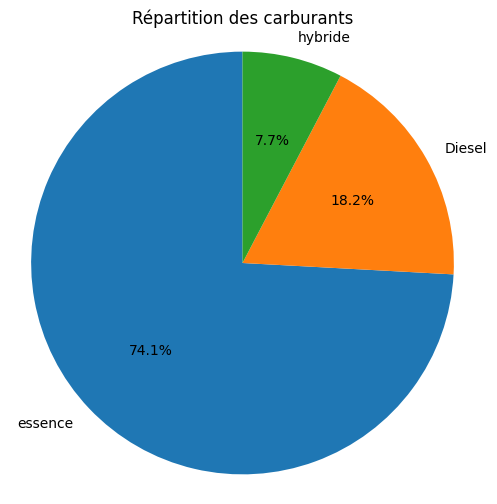

In [ ]:
# Groupement et comptage
df_count = df.group_by("energie").agg(pl.count())

# Tri décroissant
df_count = df_count.sort("count", descending=True)

# Extraction des labels et valeurs
labels = df_count["energie"].to_list()
sizes = df_count["count"].to_list()

# Camembert
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Répartition des carburants")
plt.axis("equal")
plt.show()

# La majorité des véhicules utilisent de l'essence, on a que 8% en hybride e 18% en diesel

In [ ]:
df.columns

['marque',
 'modele',
 'prix',
 'annee',
 'kilometrage',
 'energie',
 'nombre chevaux',
 'code postal',
 'latitude',
 'longitude',
 'ville',
 'région']

In [ ]:
# Conversion en Pandas pour affichage Folium
df_map = df.to_pandas()

# Création de la carte
m = folium.Map(location=[46.6, 2.2], zoom_start=6)

# Ajout des points avec popup info
for _, row in df_map.iterrows():
    if not pd.isna(row["latitude"]) and not pd.isna(row["longitude"]):
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=4,
            popup=(
                f"{row.get('ville', 'Ville inconnue')}<br>"
                f"Prix : {row['prix']} €<br>"
                f"Énergie : {row['energie']}"
            ),
            color="blue",
            fill=True,
            fill_opacity=0.6,
        ).add_to(m)

# Affichage dans Jupyter Notebook
m

#m.save("carte_voitures.html")

# On peut voir que nos voitures en vente sont repartis généralement sur tout le territoire


<Axes: ylabel='marque'>

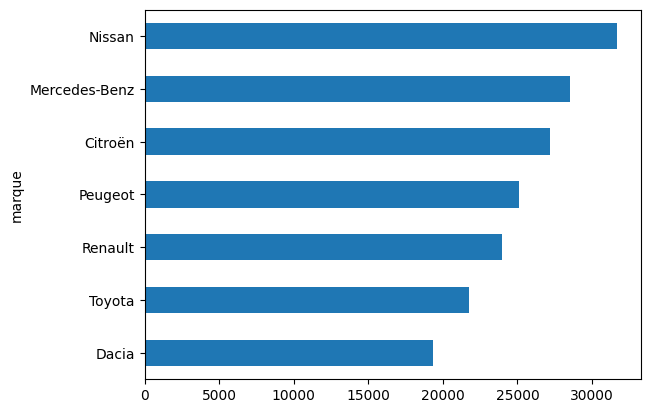

In [ ]:
# Prix moyens par marques 
df_g = df.to_pandas()
df_g.groupby("marque")["prix"].mean().sort_values().plot(kind="barh")

# Les plus chères sont les Nissans mais les voitures restenet toutefois comparables en termes de prix car pas très éloignés

<Axes: xlabel='annee'>

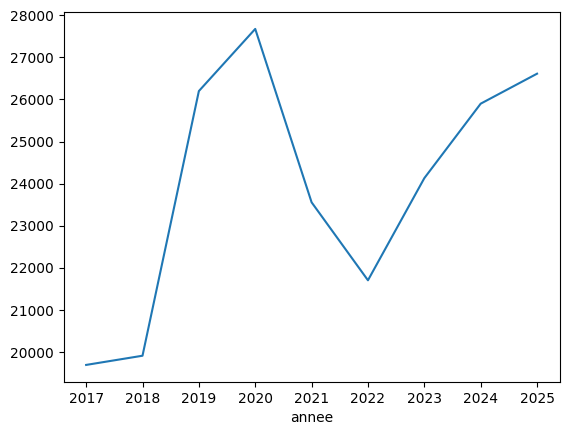

In [ ]:
#
df_x = df.to_pandas()
df_x.groupby ("annee")["prix"].mean().plot()

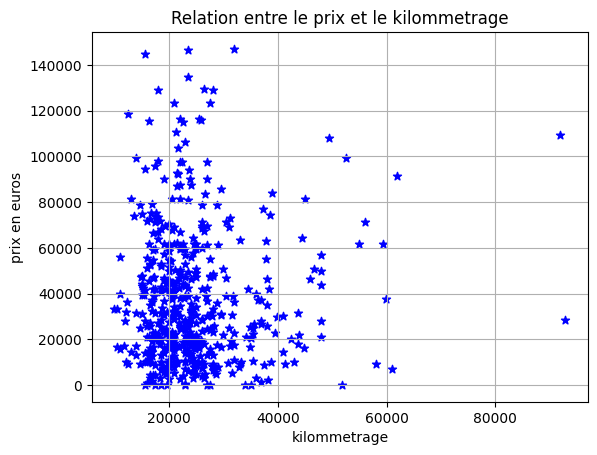

In [ ]:
import matplotlib.pyplot as plt

# Nuage de points
plt.scatter(df['prix'], df['kilometrage'], color='blue', marker='*')
plt.title("Relation entre le prix et le kilommetrage")
plt.xlabel("kilommetrage")
plt.ylabel("prix en euros")
plt.grid(True)
plt.show()

In [ ]:
fig = px.scatter_mapbox(
    df_map,
    lat="latitude",
    lon="longitude",
    color="prix",
    size="prix",
    hover_name="ville",
    hover_data=["marque", "modele", "annee", "energie"],
    color_continuous_scale=px.colors.cyclical.IceFire,
    zoom=5,
    height=600
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0}, title="Carte des voitures par prix")
fig.write_html("carte.html")


C:\Users\lenovo\AppData\Local\Temp\ipykernel_10048\888415216.py:1: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# Modèles

## Modalités

In [ ]:
# Modalité
# Voir les modalités de la colonne "energie"
modalites_marque = df.select("marque").unique()
print(list(modalites_marque))

# Voir les modalités de la colonne "energie"
modalites_modele = df.select("modele").unique()
for val in modalites_modele:
    print(list(val))


# Voir les modalités de la colonne "energie"
modalites_energie = df.select("energie").unique()
print(modalites_energie)

[shape: (7,)
Series: 'marque' [str]
[
	"Dacia"
	"Toyota"
	"Mercedes-Benz"
	"Nissan"
	"Renault"
	"Citroën"
	"Peugeot"
]]
['Spring', 'C4 X', 'e-2008', 'Clio', 'C-HR', 'Megane R.S.', 'Arkana', 'Classe A', 'Classe C', 'Qashqai', '308 SW', 'Megane', 'Megane E Tech', 'Sandero', 'Yaris', '2008', 'Captur', 'GLA', 'Sandero Stepway', 'C3']
shape: (3, 1)
┌─────────┐
│ energie │
│ ---     │
│ str     │
╞═════════╡
│ Diesel  │
│ essence │
│ hybride │
└─────────┘


In [ ]:
# Supression des variables qui dérangent mon modèle
df =  df.drop(["latitude", "longitude", "ville","code postal"])


In [ ]:
from polars import String
features_modalities = []
for feature_name, feature_type in df.schema.items():
    if isinstance(feature_type, String):
        modalities = [str(x) for x in df[feature_name].unique().to_list()]
        features_modalities.append(f"{feature_name} ({feature_type}) : " + ",".join(modalities) + "\n")
    else:
        features_modalities.append(f"{feature_name} ({feature_type}) \n")

with open("features_modalities.txt", "w", encoding="utf-8") as f:
    f.writelines(features_modalities)

In [ ]:
#df = df.to_pandas()
# --- Exporter le DataFrame en CSV ---
#df.to_csv('vehicules1.csv', index=False)  # Le fichier sera créé dans le répertoire courant

# Transformation en dumnies pour les modèles
df = df.to_dummies(cs.string(), separator="_",  drop_first=True)

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [ ]:
df.describe()

statistic,marque_Citroën,marque_Dacia,marque_Mercedes-Benz,marque_Nissan,marque_Peugeot,marque_Toyota,modele_2008,modele_308 SW,modele_Arkana,modele_C-HR,modele_C3,modele_C4 X,modele_Captur,modele_Classe A,modele_Classe C,modele_GLA,modele_Megane,modele_Megane E Tech,modele_Megane R.S.,modele_Qashqai,modele_Sandero,modele_Sandero Stepway,modele_Spring,modele_Yaris,modele_e-2008,prix,annee,kilometrage,energie_Diesel,energie_hybride,nombre chevaux,région_Auvergne-Rhône-Alpes,région_Bourgogne-Franche-Comté,région_Bretagne,région_Centre-Val de Loire,région_Grand Est,région_Hauts-de-France,région_Normandie,région_Occitanie,région_Pays de la Loire,région_Provence-Alpes-Côte d'Azur,région_Île-de-France
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0,494.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.016194,0.032389,0.05668,0.040486,0.074899,0.01417,0.008097,0.002024,0.087045,0.002024,0.01417,0.002024,0.346154,0.020243,0.008097,0.02834,0.125506,0.012146,0.002024,0.040486,0.020243,0.006073,0.006073,0.012146,0.064777,24497.394737,2022.202429,37570.892713,0.182186,0.074899,144.708502,0.11336,0.089069,0.036437,0.072874,0.08502,0.02834,0.05668,0.072874,0.058704,0.078947,0.161943
"""std""",0.12635,0.17721,0.231465,0.197296,0.263495,0.118311,0.08971,0.044992,0.282186,0.044992,0.118311,0.044992,0.476225,0.140973,0.08971,0.166111,0.331628,0.109647,0.044992,0.197296,0.140973,0.07777,0.07777,0.109647,0.246382,9569.521302,1.638629,29340.849549,0.386389,0.263495,31.005268,0.317354,0.285132,0.187565,0.260194,0.279195,0.166111,0.231465,0.260194,0.235309,0.26993,0.368772
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9950.0,2017.0,5.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18778.0,2021.0,16200.0,0.0,0.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22490.0,2022.0,30115.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26990.0,2024.0,52072.0,0.0,0.0,155.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""max""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,92900.0,2025.0,147047.0,1.0,1.0,300.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
y = df['prix']
X = df.drop('prix')

In [ ]:
X.columns

['marque_Citroën',
 'marque_Dacia',
 'marque_Mercedes-Benz',
 'marque_Nissan',
 'marque_Peugeot',
 'marque_Toyota',
 'modele_2008',
 'modele_308 SW',
 'modele_Arkana',
 'modele_C-HR',
 'modele_C3',
 'modele_C4 X',
 'modele_Captur',
 'modele_Classe A',
 'modele_Classe C',
 'modele_GLA',
 'modele_Megane',
 'modele_Megane E Tech',
 'modele_Megane R.S.',
 'modele_Qashqai',
 'modele_Sandero',
 'modele_Sandero Stepway',
 'modele_Spring',
 'modele_Yaris',
 'modele_e-2008',
 'annee',
 'kilometrage',
 'energie_Diesel',
 'energie_hybride',
 'nombre chevaux',
 'région_Auvergne-Rhône-Alpes',
 'région_Bourgogne-Franche-Comté',
 'région_Bretagne',
 'région_Centre-Val de Loire',
 'région_Grand Est',
 'région_Hauts-de-France',
 'région_Normandie',
 'région_Occitanie',
 'région_Pays de la Loire',
 "région_Provence-Alpes-Côte d'Azur",
 'région_Île-de-France']

In [ ]:
with open(rootPath / "feature_names.txt", "w", encoding="utf-8") as f:
    for feature in X.columns:
        f.write(feature + "\n")

# Remove features names
X = X.to_numpy()

# Entrainement des modeles

In [ ]:
import sklearn
sklearn.__version__

'1.6.1'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [ ]:
lin_reg.coef_

array([ 1.89701652e+03, -1.73118617e+03,  1.13405894e+03,  3.22096342e+03,
        7.16023895e+03, -7.11671072e+02,  5.63784753e+03,  6.64740695e+03,
        2.28721833e+03, -1.52498986e+03,  5.17837183e+03, -3.28135531e+03,
        1.53110110e+03,  2.11075344e+03, -5.08265121e+03,  4.10595671e+03,
        4.43468455e+03, -3.73585898e+03,  1.30275447e+03,  3.22096342e+03,
        2.62536260e+03, -7.14870359e+02, -3.64167841e+03,  8.13318788e+02,
       -5.12501553e+03,  5.01057573e+02,  3.47177488e-02,  3.89735652e+02,
       -8.03176654e+02,  5.99169125e+01,  1.77940976e+03,  9.80151556e+02,
       -2.35010858e+03, -6.71268894e+02, -2.82861161e+03, -4.11812339e+03,
        1.33598338e+03,  5.67491681e+02, -9.16157305e+02, -1.37166957e+03,
        1.26441830e+03])

In [ ]:
gb_model = GradientBoostingRegressor()
import time
start_time = time.time()
gb_model.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.29402756690979004 seconds ---


In [ ]:
kn_model = KNeighborsRegressor()
import time
start_time = time.time()
kn_model.fit(X, y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.001996755599975586 seconds ---


In [ ]:
# Random forest

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

start_time = time.time()
y_pred = rf_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
print("--- %s seconds ---" % (time.time() - start_time))


MSE: 141373462.4355374
R²: -0.03784865395154968
--- 0.01842522621154785 seconds ---


In [ ]:
# Enregistrer les modèles
from pathlib import Path
import os
model_location = Path(".").parent / "models"
if not os.path.exists(model_location):
  os.mkdir(model_location)

import pickle

model_export_names = ["LinearReg_Model.pkl", "GradientB_Model.pkl", "KNN_Model.pkl", "RF_Model.pkl"]

for model, export_name in zip([lin_reg, gb_model, kn_model, rf_model], model_export_names):
  with open(model_location / export_name, "wb") as f:
    pickle.dump(model, f)